In [37]:
import sys
sys.path.append(r"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas")

# my custom module
import PyHistone as his

# data analysis modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import re

# statistical packages 
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn import preprocessing 

# Important parameters 

In [38]:
# Important parameters for the analysis pipeline that WILL impact the final results

# 1. Set the control sample
control = "Control"


# <- add samples to be removed from the quality check steps
poor_samples = [
                "Ctrl-B1-T1",
                "Ctrl-B1-T2",
                "Ctrl-B2-T1",
                ]   


# coefficient of variance cutoff (how much a peptide is allowed to vary WITHIN groups before we consider it to be too variable)
variability_cv_cutoff = 0.8
percent_absent = 0.5
# ^- if a peptide is only present in 30% of samples or less, we'll remove it 


# The method by which we will normalise our samples
norm_method = "Peptide" # "total_signal"


# If we want to combine modifications that are difficult to disambiguate
merge_similar = True 

# if we want to do FDR correction on our p-values after our ANOVA we set this to be true
fdr_after_anova=True

---
---
## **1. Data import**

- First we load in the file 
- The spreadsheet is in a wierd format, we specifically want to select the XIC-Area columns (from the middle) 
- To improve generalisability, this script assumes you already have an Excel sheet mapping the long sample names to the abbreviated ones (see the Github for the excel File I made) 

As this section is mostly routine, i have encapsulated it within a function. 

In [39]:
histone_data = his.load_rename(
    EpiProfile_output="EpiPro2.2.csv",      # <--- change this line to your data
    SamplesToAbbrev  ="IMR575_samples.xlsx" # <--- change this line to your sample MetaData
    )


**Reformat the peptide names to make them look nicer**

In [40]:
# Renaming the peptides
histone_data.index=[his.peptide_namecleaner(pep) for pep in histone_data.index]

In [41]:
# Convert all the datapoints to numeric if hasnt already been done
histone_data=histone_data.astype(float)

---
---
## **2. Combine mods that can be difficult to disambiguate**

I am personally skeptical over whether this is a necessary step as in my experience EpiProfile was reasonably good at differentiating these mofifications (data unpublished), however you may choose to do so.  

the below function will combine several modifications, including the many mods found on the H4[4-17] peptide. 

In [42]:
# Comment this out if you dont want to combine modifications 

if merge_similar:
    histone_data = his.combine_similar(histone_data)

---
---
## **3. Data Quality Checks**
Check if the data was of sufficient quality to be processed by EpiProfile

**1. Check for modifications that should be consistently identified in all samples.**

NOTE: Histone 3.3 can be difficult to identify in some samples, so its absence may not necessarily indicate poor data 

In [43]:
common_mods=r"H3_18_26_K(18|23)ac$|H3_27_40_K27me\d$|H33_27_40_K27me\d$|H3_9_17_K(9|14)ac$|H4_4_17_unmod|H3_3_8_unmod|H3_73_83_K79me1$"
common_mods=[pep for pep in histone_data.index if re.search(pattern=common_mods, string=pep)]

print("Common modifications that should be present")
display(common_mods)
print("Number of common modifications missing from each sample")
print(pd.DataFrame(histone_data.loc[common_mods]==0).sum())

Common modifications that should be present


['H3_3_8_unmod',
 'H3_27_40_K27me1',
 'H3_27_40_K27me2',
 'H3_27_40_K27me3',
 'H33_27_40_K27me1',
 'H33_27_40_K27me2',
 'H33_27_40_K27me3',
 'H3_73_83_K79me1',
 'H4_4_17_unmod']

Number of common modifications missing from each sample
Ctrl-B3-T1        2
DOX+ 72h-B1-T1    2
DOX+ 72h-B2-T1    2
DOX+ 72h-B3-T1    2
DOX-DPI+-B1-T1    2
DOX-DPI+-B2-T2    2
DOX-DPI+-B3-T1    2
DOX+DPI+-B1-T2    2
DOX+DPI+-B2-T1    2
DOX+DPI+-B3-T1    2
Ctrl-B2-T1        3
Ctrl-B2-T2        2
Ctrl-B3-T2        2
DOX+ 72h-B1-T2    2
DOX+ 72h-B2-T2    2
DOX+ 72h-B3-T2    2
DOX-DPI+-B1-T2    2
DOX-DPI+-B2-T1    1
DOX-DPI+-B3-T2    2
DOX+DPI+-B1-T1    2
DOX+DPI+-B2-T2    2
DOX+DPI+-B3-T2    2
Ctrl-B1-T1        2
Ctrl-B1-T2        4
dtype: int64


**Remove poor quality samples**

In [44]:
histone_data=histone_data.drop(poor_samples,axis=1)

**2. Remove low-abundance peptides**

This is important for normalisation (see thomas et al for explanation)

Removing peptides that were absent in *10* or more of the *21* samples
Removing peptides that had an average signal less than *100000.0*

Typically these two filters will mostly remove the same peptides


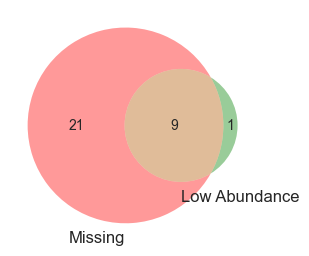

In [45]:
# Identify peptides that were missing in a lot of samples
num_samples = len(histone_data.columns)
missing_tolerance = int(num_samples*percent_absent)
missing_peps = histone_data[
    (histone_data==0).sum(axis=1) > missing_tolerance
    ].index

print(f"Removing peptides that were absent in *{int(missing_tolerance)}* or more of the *{num_samples}* samples")


min_avg_signal=1e5
low_abun_peps = histone_data.index[histone_data.mean(axis=1) < min_avg_signal]
print(f"Removing peptides that had an average signal less than *{min_avg_signal}*")

print("\nTypically these two filters will mostly remove the same peptides")
plt.figure(figsize=(12,3))
venn2(subsets=(set(missing_peps),set(low_abun_peps)), 
      set_labels=("Missing","Low Abundance"))
plt.show()

histone_data=histone_data.drop(list(set(missing_peps) | set(low_abun_peps)))

**3. Check overall signal for each peptide and each sample**

For this we need to calculate total peptide signal (which we might use later for normalisation)

All peptides seem to be present in similar relative amounts, which indicates this is an excellent quality dataset

However we can see that the PANC samples had particularly low signal overall. 

This isnt a major issue, however it may explain why one of the PANC samples was missing a commonly found modification (see above)

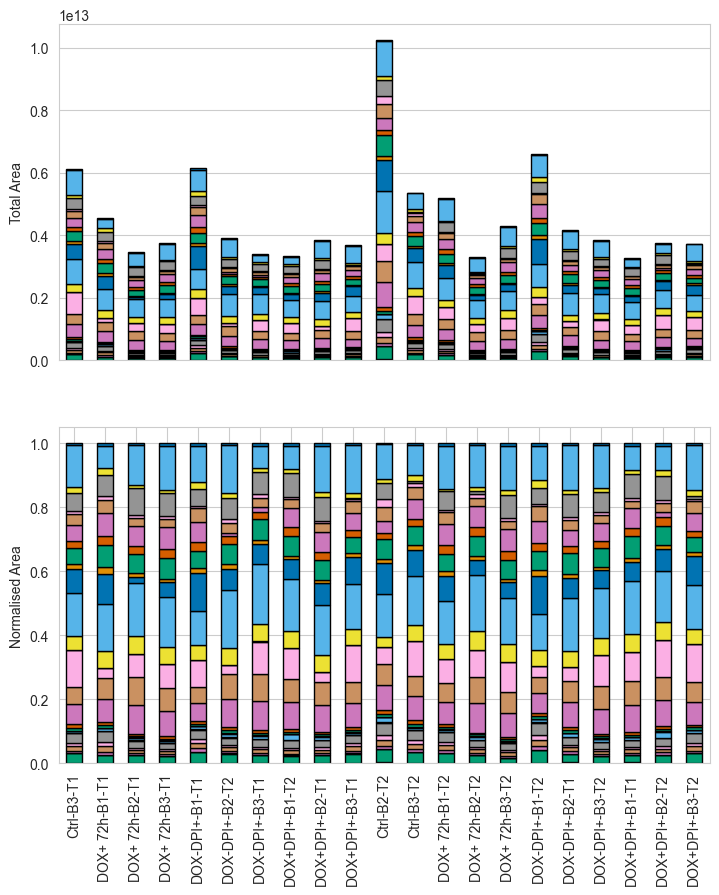

In [46]:
#peptide_totals, peptide_data = peptide_fam_stats(histone_data)

peptide_data = histone_data.copy()
pat=r'(H.+_\d+_\d+)_'
peptide_data["Peptide_id"] = [re.search(pat,pep).group(1) for pep in peptide_data.index]
peptide_totals=peptide_data.groupby("Peptide_id").sum()

# See the module script for details of this function
his.signal_plot(peptide_totals)

---
---
## **4. Normalisation**

There are two very important considerations at this step as outlined by Thomas et al. 

1. Removal of low-abundance peptides (previously done)
2. Peptides with few modifications (read the paper for details)

In [47]:
def normalise_data(histone_data, norm_method, drop_singles=False):
    # Create Peptide data as a copy of histone data
    peptide_data = histone_data.copy()

    # using this pattern, extract the peptide IDs
    pat=r'(H.+_\d+_\d+)_'
    peptide_data["Peptide_id"] = [re.search(pat,pep).group(1) for pep in peptide_data.index]
    
    # drop peptides with only one form identified.
    if drop_singles:
        singletons = peptide_data.groupby("Peptide_id").size()
        singletons = singletons[singletons == 1].index
        peptide_data = peptide_data[~peptide_data["Peptide_id"].isin(singletons)]
    

    # Normalise by peptide
    if norm_method =="Peptide":
        # calculate total indensities for each peptide family
        peptide_totals=peptide_data.groupby("Peptide_id").sum()
    
        def pep_norm(row):
            # A row-wise function used to normalise by peptide family
            peptide_id = row["Peptide_id"]
            row_norm_factors = peptide_totals.loc[peptide_id].replace(0, np.nan)
            row_data = row.drop("Peptide_id")
            return row_data/row_norm_factors

        normalised = peptide_data.apply(pep_norm,axis=1)
        print(norm_method)

    # Normalise by total signal
    if norm_method =="total_signal":
        data_only=peptide_data.drop("Peptide_id",axis=1)
        normalised = data_only.div(data_only.sum()) 

    return normalised


In [48]:
normalised = normalise_data(histone_data,
                            norm_method=norm_method,
                            drop_singles=True
                            )


Peptide


---
---
## **5. Assessing Sample Consistency**



First we need to group the samples by condition

In [49]:
# Need to have a metadata dictionary to group the samples by condition
metadata =pd.read_excel("IMR575_samples.xlsx")
metadata = {key: val for key, val in zip(metadata["Abbreviated_names"], metadata["Group"])}

normalised=normalised.T
normalised["Group"] = normalised.index.map(metadata)
group_mean = normalised.groupby("Group").mean()
group_std = normalised.groupby("Group").std()

# then we remove samples with a very high coefficient of variation 
cv = group_std/group_mean.replace(0,np.nan)
too_variable = list(cv.columns[cv.mean(axis=0) >variability_cv_cutoff])


histone_data=histone_data.drop(too_variable,axis=0)   # drop the bad peptides from the original dataframe

**At this stage we impute with low values**

In [50]:
histone_data=histone_data.replace(0,1e5)

Renormalise after removing the bad peptides and imputing

In [51]:
normalised = normalise_data(histone_data,
                            norm_method=norm_method,
                            drop_singles=True
                            )

Peptide


In [52]:
def get_speardist(u,v):
    corr, _ = stats.spearmanr(u,v)
    return 1-corr

# samples are originally in columns so we transpose 
spearmandis_matrix = pd.DataFrame(
    squareform(
        pdist(
            np.array(normalised.T),
            metric=get_speardist
        )
    )
)

spearmandis_matrix.columns = normalised.T.index
spearmandis_matrix.index = normalised.T.index

c:\Users\Tim\Anaconda\envs\bulk_rna\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\Tim\Anaconda\envs\bulk_rna\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


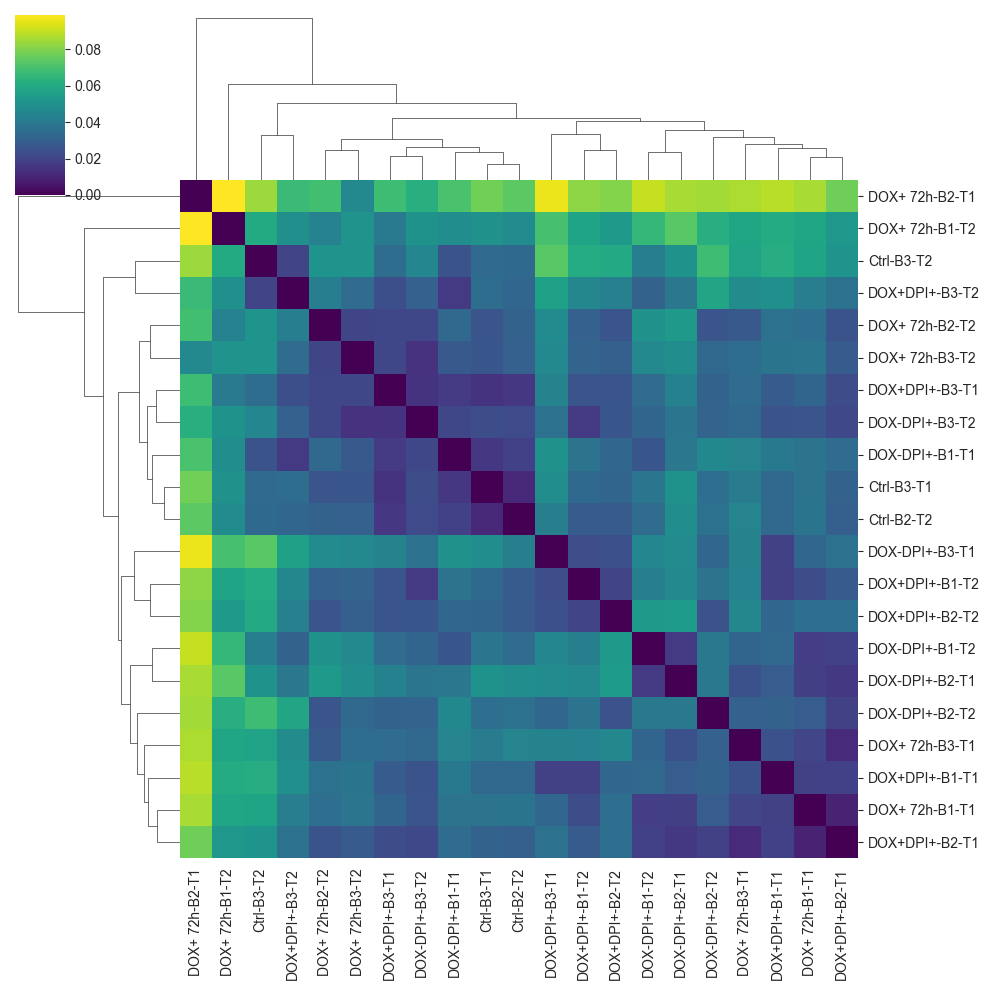

In [53]:
sns.clustermap(
    spearmandis_matrix,
    cmap="viridis",
    #vmin=0, vmax=.05
)

In [54]:
# properly format our metadata
meta = pd.DataFrame(metadata.items())
meta=meta.set_index(0)
meta.index.name = "Sample"
meta.columns=["Cell line"]

Keep in mind the scaling algorithm for PCA is slightly different between R and Python so the PCA plot will look different, however notably the feature contributions are identical.

Text(0, 0.5, 'PC2 (14.6%)')

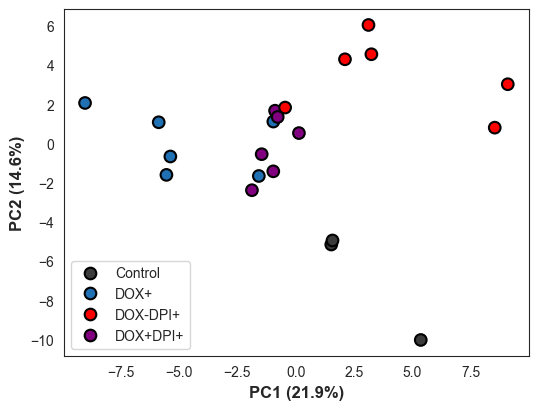

In [55]:
sns.set_style("white")

plt.figure(figsize=(6,4.5))
pca,pca_data =his.pc_autom(
                        t_dataset=normalised.T,
                        metadata=meta
                        )

sns.scatterplot(data=pca_data, 
                x="PC1",
                y="PC2",
                hue="Cell line",
                s=70,
                palette=['#3b3b3b', '#2070b4', 'Red', 'purple'],
                edgecolor="black",linewidth=1.5
                )


explained_var = pca.explained_variance_ratio_

var_ex = np.round(
    explained_var*100,
    decimals=1
)
plt.legend(loc="lower left")

plt.xlabel(f"PC1 ({var_ex[0]}%)", fontsize=12, fontweight="bold")
plt.ylabel(f"PC2 ({var_ex[1]}%)",fontsize=12, fontweight="bold")
#plt.savefig(r"C:\Users\Tim\OneDrive\__ThesisProject\Figures\H3K9acFigure\pcaIMR575.svg",dpi=300)


---
---
## **6. Statistics & Analysis**


In [56]:
normalised.to_csv(r"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\New_Comparative\imr575.csv")

normalised_groups = normalised.T
normalised_groups["Group"] = [meta.loc[sample].values[0] for sample in normalised_groups.index]

**Calculate Fold-Changes relative to control**

(unlike their script i've only done relative to control (which is set at the start of this script) rather than all samples relative to eachother as that gets a bit confusing)


In [57]:
# Calculate fold-changes
fc = his.histone_foldchanges(normalised,control,meta)
fc.to_csv(r"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\New_Comparative\imr575_fc.csv")

# Calculate tukey p-values 
stats_df , TukeyPval_df = his.histone_AnovaTukey(normalised,meta,control,fdr_correct=fdr_after_anova)

**From here, we can generate whatever figures we want**

In [58]:
# re-order the columns 
fc = fc[["DOX-DPI+","DOX+","DOX+DPI+"]]
TukeyPval_df=TukeyPval_df[["DOX-DPI+","DOX+","DOX+DPI+"]]

# Make the columns more understandable
fc.columns = ["DPI","DOX","DPI+DOX"]
TukeyPval_df.columns = ["DPI","DOX","DPI+DOX"]

In [59]:
normalised_groups["Group"]=normalised_groups["Group"].map({
    "Control":"Control",
    "DOX+":"DOX",
    "DOX-DPI+":"DPI",
    "DOX+DPI+":"DOX+DPI"
})

In [60]:
sample_cols = ["#3b3b3b","red","#2070b4","purple"]

# Volcano plots 

In [61]:
interesting_mods=["H3_K9acK14ac","H2A1_K5acK9ac",
                    "H3_K9/K14ac","H2A1_K5/K9ac",
                    # "H3_K18me1","H4_4ac"
                    ]

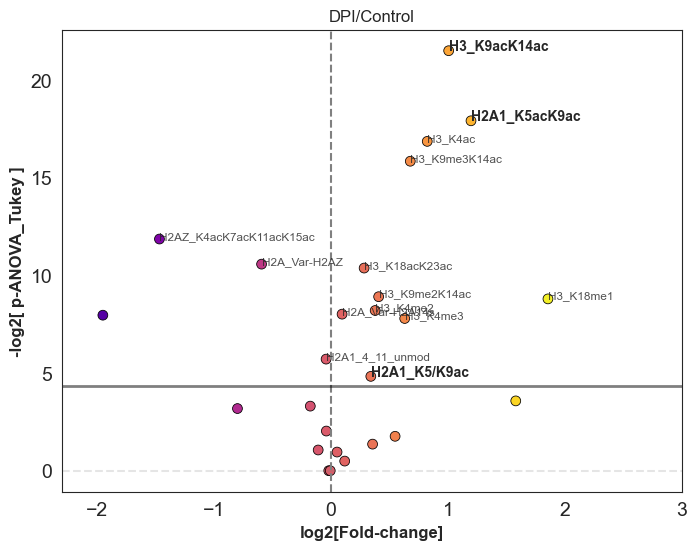

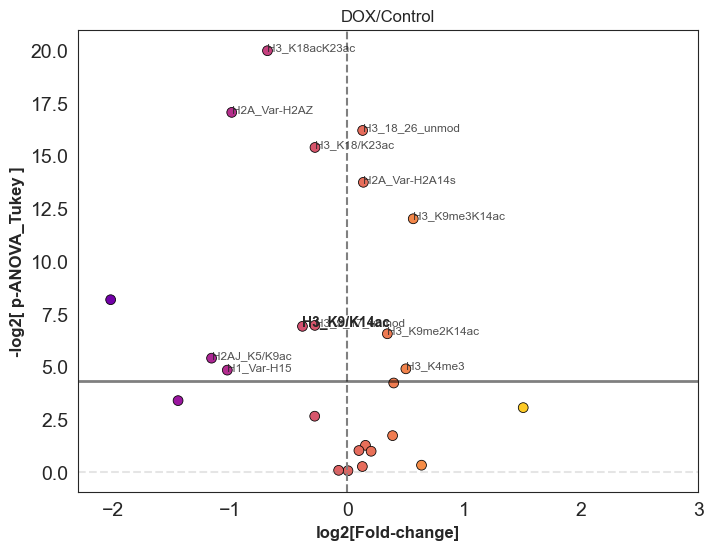

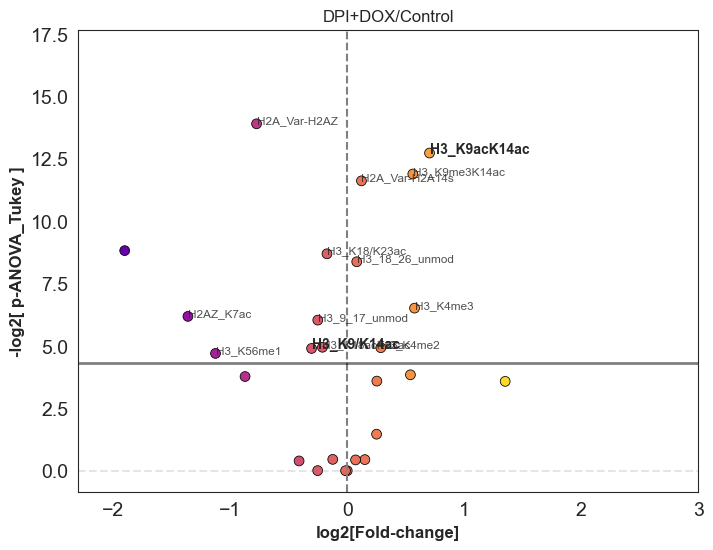

In [62]:
sns.set_style("white")
interestinglist=[]
for treatment in fc.columns:
    a = pd.DataFrame(fc[treatment].apply(np.log2))
    a.columns = ["FC"]


    b = pd.DataFrame(TukeyPval_df[treatment].apply(lambda p:-np.log2(p)))
    b.columns = ["ANOVA-Tukey"]

    df = pd.merge(a,b,left_index=True, right_index=True)


    plt.figure(figsize=(8,6))

    sns.scatterplot(
        data=df,
        x="FC",
        y="ANOVA-Tukey",
        hue="FC",
        palette="plasma",  # plasma
        edgecolor="black",
        s=50,
    )
    #plt.axvline(0.5, color="black", linestyle="--", alpha=0.5)
    plt.axvline(0, color="grey",linestyle="--", alpha=1)
    plt.axhline(-np.log2(0.05), color="black", linestyle="-", alpha=0.5, linewidth=2)
    plt.axhline(0, color="grey",linestyle="--", alpha=0.2)

    for peptide in df.index:
        displaystring = his.peptide_namecleaner(peptide,rem_number=True)
        if (
            (df.loc[peptide, "ANOVA-Tukey"] >= -np.log2(0.05))
            & (df.loc[peptide, "FC"] > -1.5)
            ):
            if displaystring in interesting_mods:
                fntwt="bold"
                fntsz=10
                alpha=1
            else:
                fntwt=None
                fntsz=8.5
                alpha=0.8


            # if it is really significant  
            plt.text(
                s=displaystring,
                y=df["ANOVA-Tukey"].loc[peptide],
                x=df["FC"].loc[peptide],
                fontsize=fntsz,
                fontweight=fntwt,
                alpha=alpha,
                #va="center",
                #ha="right"
                )


        elif df["ANOVA-Tukey"].loc[peptide] >=-np.log2(0.05):
            continue
            # if the p-value is significant from correction
            plt.text(s=displaystring,
                    y=df["ANOVA-Tukey"].loc[peptide],
                    x=df["FC"].loc[peptide],
                    fontsize=8,
                    va="center",ha="center")


    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(-2.3,3)
    plt.ylabel("-log2[ p-ANOVA_Tukey ]",fontweight="bold",fontsize=12)
    plt.xlabel("log2[Fold-change]",fontweight="bold",fontsize=12)

    
    plt.title(f"{treatment}/{control}")
    plt.legend().remove()
    
    #plt.savefig(fr"C:\Users\Tim\OneDrive\__ThesisProject\Figures\H3K9acFigure\volcano{treatment}.svg",dpi=300)

    plt.show()

In [63]:
a = pd.read_csv("EpiPro2.2.csv",index_col=0)
a["1,250312kw_StephanieHistoneTest03.1"].loc["H3_9_17 K9acK14ac"]

'4.032522e+08'

# Heatmap

C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\PyHistone.py:420: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heat_fcs = fc.applymap(np.log2)
C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\PyHistone.py:421: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sigmap = TukeyPval_df[heat_fcs.columns].applymap(asterisker)
C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\PyHistone.py:420: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heat_fcs = fc.applymap(np.log2)
C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\PyHistone.py:421: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sigmap = TukeyPval_df[heat_fcs.columns].applymap(asterisker)
C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\Pythonify_Thomas\PyHistone.py:420: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map 

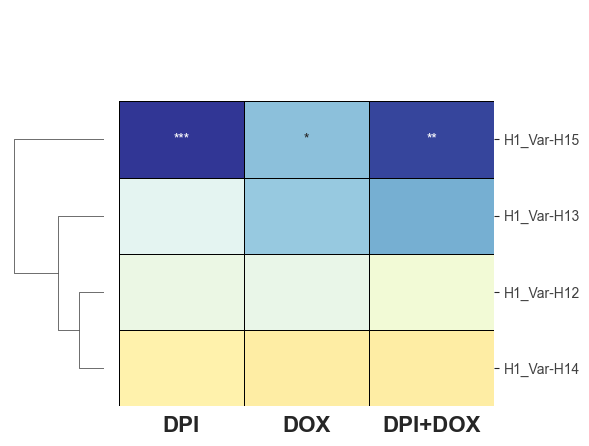

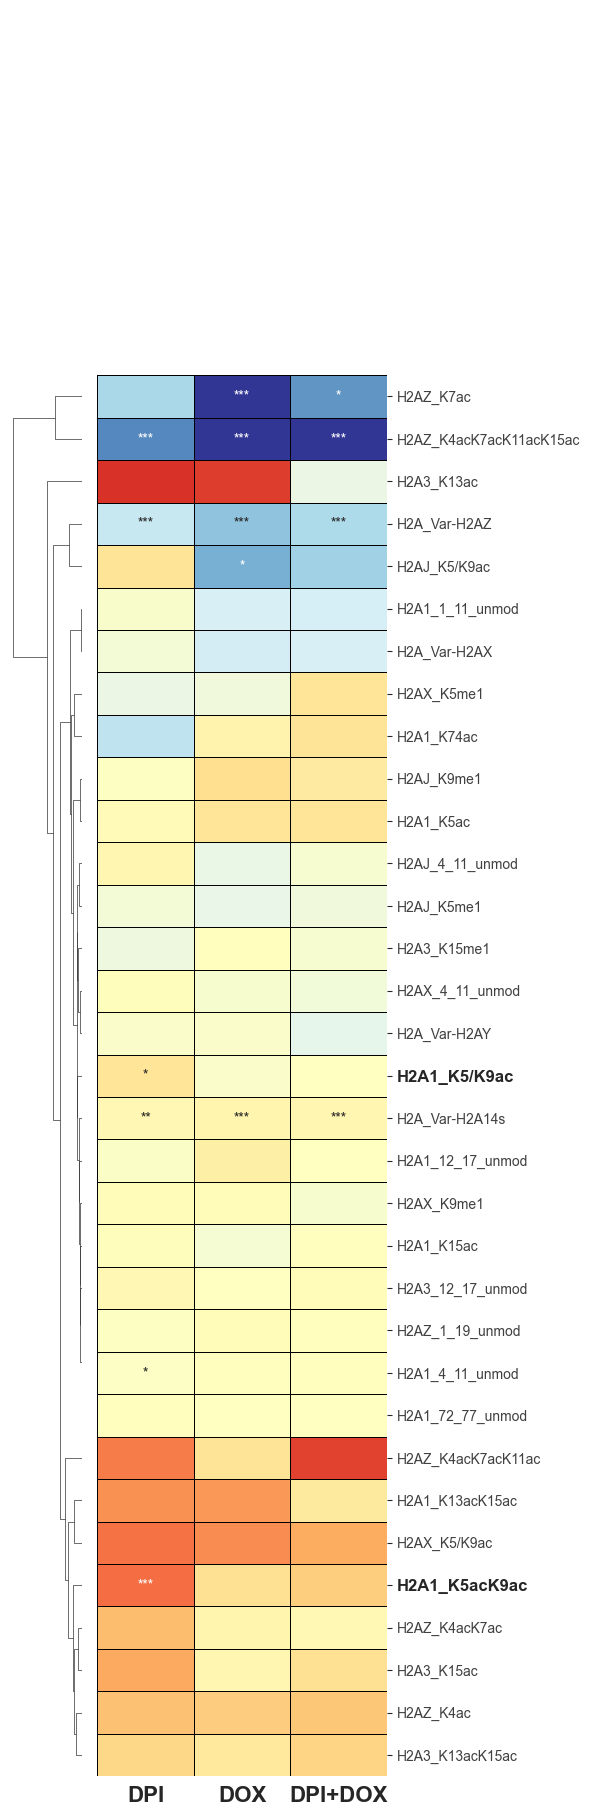

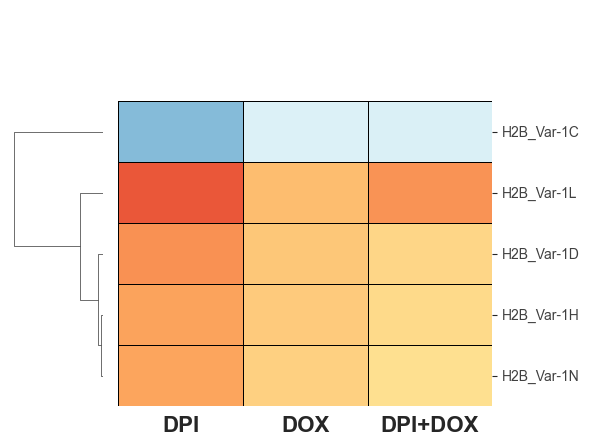

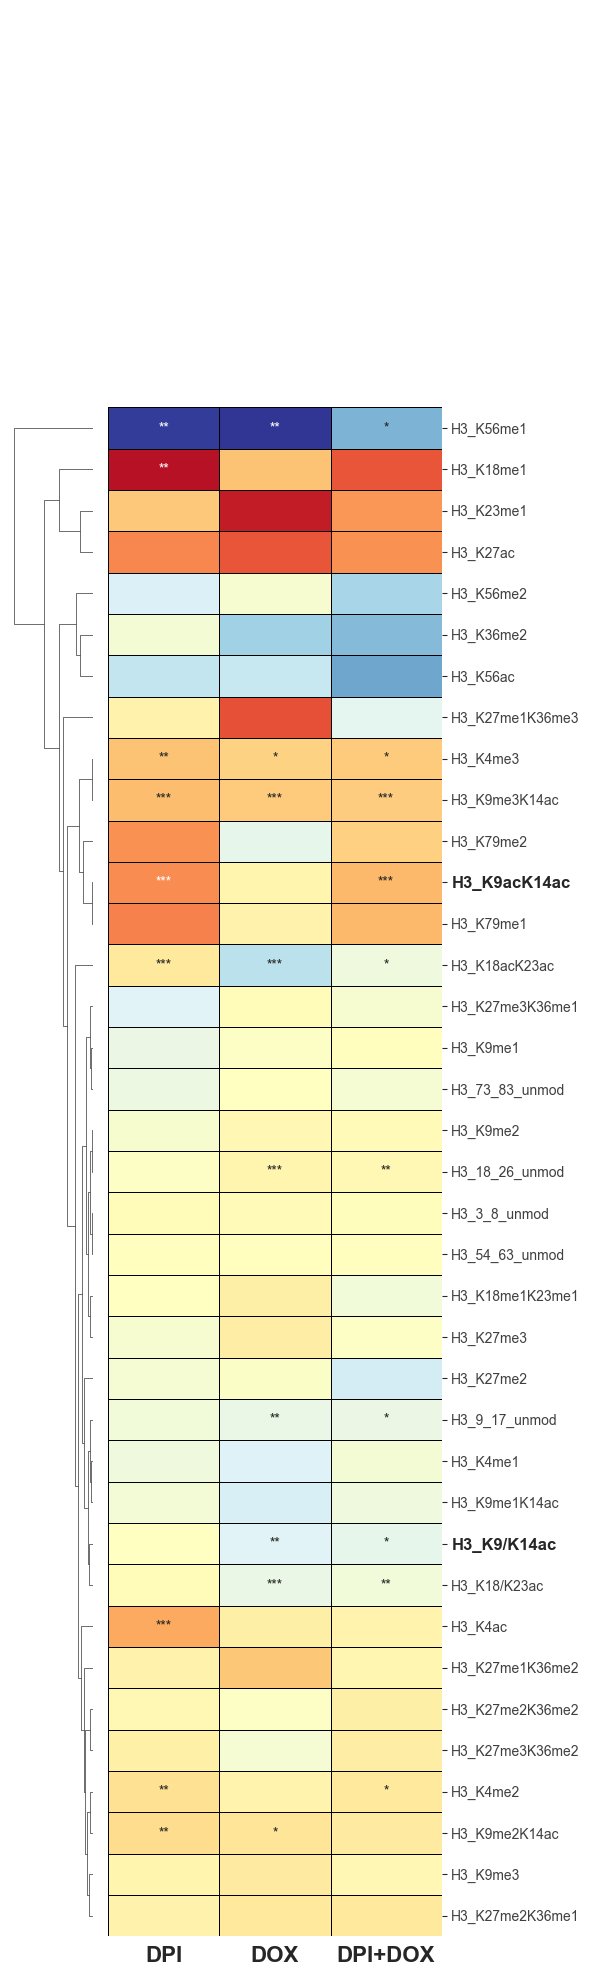

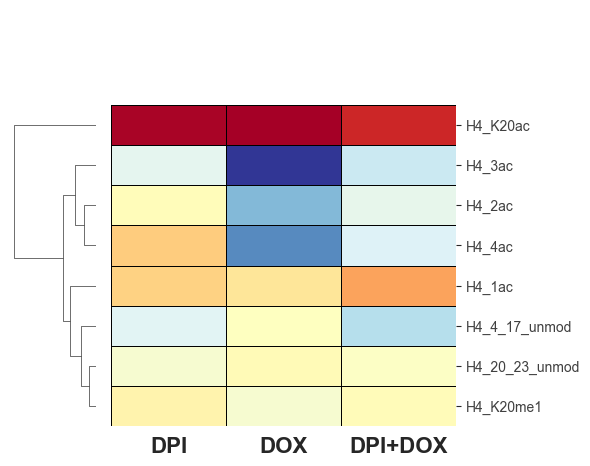

In [64]:
figwidth ={
    "H1" : lambda x: 4.5,
    "H2A": lambda x: len(x)/2.5+5,
    "H2B": lambda x: 4.5,
    "H3": lambda x: len(x)/2.5+5,
    "H4": lambda x: len(x)/1.7,
}
histone_names = ["H1","H2A","H2B","H3","H4"]

for name in histone_names:
    histone_peptides = [pep for pep in fc.index if pep.startswith(name)]
    heat_fcs, sigmap = his.heat_sigmap(fc.loc[histone_peptides],TukeyPval_df.loc[histone_peptides])


    g =sns.clustermap(heat_fcs, 
               cmap=  "RdYlBu_r",   # seismic" # icefire ,  # 	RdYlBu_r

               center=0,
               annot=sigmap, 
               fmt="",
               col_cluster=False, 
               metric="cityblock", # cosine euclidean cityblock
               figsize=(6, figwidth[name](heat_fcs)),
               linecolor="black", linewidths=0.5,
               vmin=-2,
               vmax=2
               )
    #g.ax_heatmap.set_title(name, fontsize=25,fontweight="bold", loc="center",pad=20)



    if name=="H2A":
        cb = g.cax
    g.cax.remove()
    g.fig.tight_layout()




    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in interesting_mods:  
            label.set_fontweight("bold")
            label.set_fontsize(12)

        else:
            label.set_c("#404040")
    
    g.cax.set_position([1, 0.2, 0.03, 0.45]) 

    g.ax_heatmap.set_xticklabels(
        g.ax_heatmap.get_xticklabels(),
        fontsize=16,
        fontweight="bold"
    )
    

    g.savefig(fr"C:\Users\Tim\OneDrive\__ThesisProject\Figures\HistoneMS_analysis\IMR575_histones\{name}.svg", facecolor='white', bbox_inches='tight')



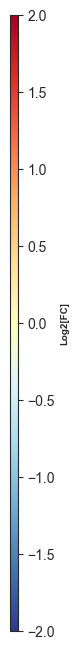

In [65]:
# Create colorbar  
fig, ax = plt.subplots(figsize=(.1, 8)) 
norm = plt.Normalize(vmin=-2, vmax=2,)
sm = plt.cm.ScalarMappable(cmap="RdYlBu_r", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=ax)
cbar.set_label("Log2[FC]", fontweight="bold",fontsize=7)
fig.savefig(r"C:\Users\Tim\OneDrive\__ThesisProject\Figures\HistoneMS_analysis\IMR575_histones\colorbar.svg", bbox_inches="tight", facecolor='white')

C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\4065957581.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


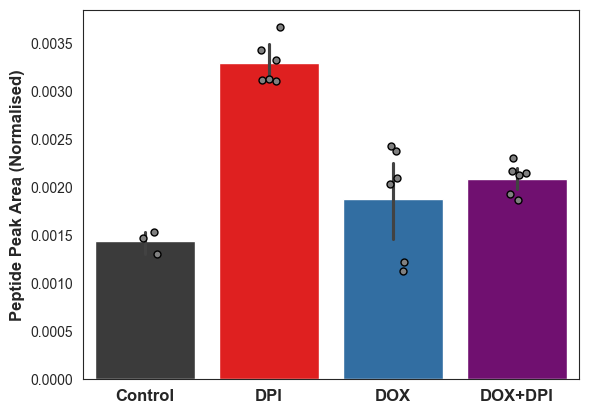

In [66]:
pep = "H2A1_4_11_K5acK9ac"

sns.stripplot(
    normalised_groups[["Group",pep]],
    y=pep,
    order=["Control","DPI","DOX","DOX+DPI"],
    x="Group",
    color="grey",edgecolor="black",linewidth=1
)
sns.barplot(
    normalised_groups[["Group",pep]],
    y=pep,
    order=["Control","DPI","DOX","DOX+DPI"],
    x="Group",
    palette=sample_cols
)

plt.xticks(fontsize=12,fontweight="bold")
plt.ylabel("Peptide Peak Area (Normalised)",fontsize=12,fontweight="bold")
plt.xlabel(None)
plt.show()

C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\2597746213.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\2597746213.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\2597746213.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Control","DPI","DOX","DOX+DPI"], #fontweight="bold",
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\2597746213.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\2597746213.py:15: FutureWarning: 

Passing `palette` wit

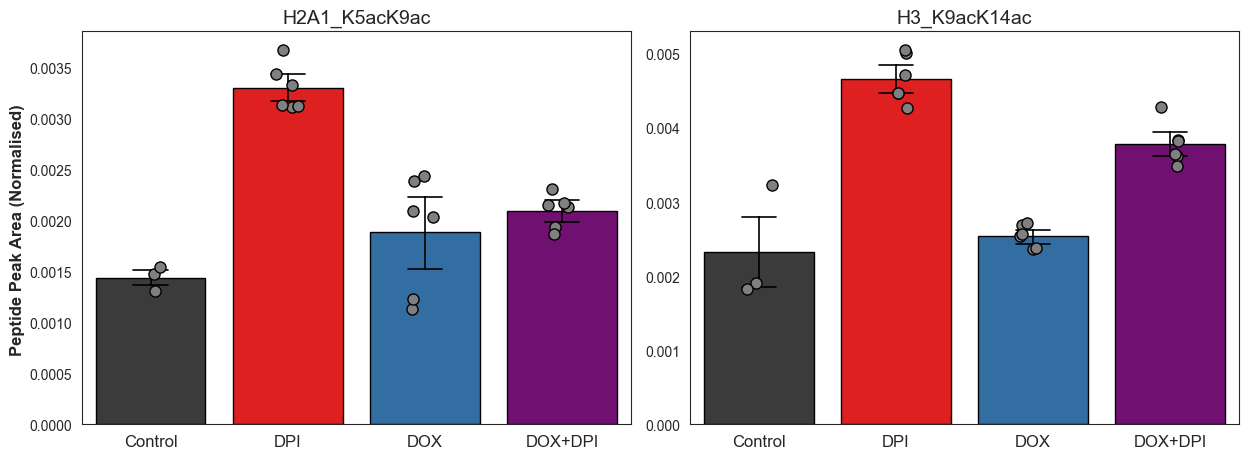

In [67]:
h=4.7
fig, axs = plt.subplots(ncols=2,figsize=(h*2.7,h))


for ax,pep in zip(axs.flatten(),["H2A1_4_11_K5acK9ac","H3_9_17_K9acK14ac"]):
    sns.stripplot(
        ax=ax,
        data=normalised_groups[["Group",pep]],
        y=pep,
        order=["Control","DPI","DOX","DOX+DPI"],
        x="Group",
        s=8,
        color="grey",edgecolor="black",linewidth=1
    )
    sns.barplot( 
        ax=ax,
        data=normalised_groups[["Group",pep]],
        y=pep,
        order=["Control","DPI","DOX","DOX+DPI"],
        x="Group",
        palette=sample_cols,
        edgecolor="black",
        ci=90,capsize=.25,
        err_kws={
            "color": "black",    
            "linewidth": 1.2, 
        },
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(his.peptide_namecleaner(pep,rem_number=True),# fontweight="bold",
                 fontsize=14)
    ax.set_xticklabels(labels=["Control","DPI","DOX","DOX+DPI"], #fontweight="bold",
                       fontsize=12)


fig.supylabel("Peptide Peak Area (Normalised)",fontsize=12,fontweight="bold")
#fig.suptitle("Di-acetylated peptides",fontsize=16, fontweight="bold")
fig.tight_layout()
#fig.savefig(fr"C:\Users\Tim\OneDrive\__ThesisProject\Figures\H3K9acFigure\raw_plots_double.svg",dpi=300)


C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1372230244.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1372230244.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1372230244.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Control","DPI","DOX","DOX+DPI"], #fontweight="bold",
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1372230244.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1372230244.py:15: FutureWarning: 

Passing `palette` wit

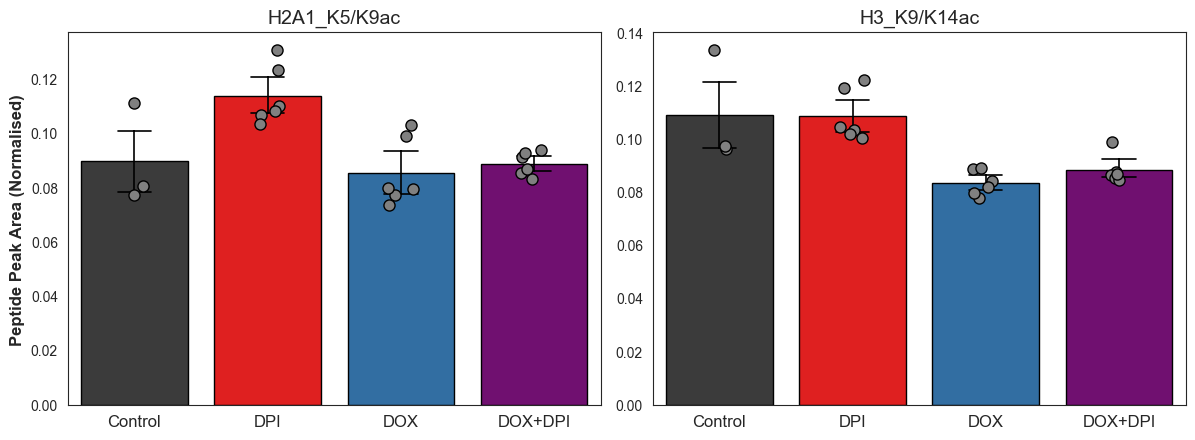

In [68]:
h=4.5
fig, axs = plt.subplots(ncols=2,figsize=(h*2.7,h))


for ax,pep in zip(axs.flatten(),["H2A1_4_11_K5/K9ac","H3_9_17_K9/K14ac"]):
    sns.stripplot(
        ax=ax,
        data=normalised_groups[["Group",pep]],
        y=pep,
        order=["Control","DPI","DOX","DOX+DPI"],
        x="Group",
        s=8,
        color="grey",edgecolor="black",linewidth=1
    )
    sns.barplot(
        ax=ax,
        data=normalised_groups[["Group",pep]],
        y=pep,
        order=["Control","DPI","DOX","DOX+DPI"],
        x="Group",
        palette=sample_cols,
        edgecolor="black",
        ci=90,capsize=.25,
        err_kws={
            "color": "black",    
            "linewidth": 1.2, 
        },
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(his.peptide_namecleaner(pep,rem_number=True), #fontweight="bold",
                 fontsize=14)
    ax.set_xticklabels(labels=["Control","DPI","DOX","DOX+DPI"], #fontweight="bold",
                       fontsize=12)


fig.supylabel("Peptide Peak Area (Normalised)",fontsize=12,fontweight="bold")
#fig.suptitle("Mono-acetylated peptides",fontsize=16, fontweight="bold")
fig.tight_layout()
#fig.savefig(fr"C:\Users\Tim\OneDrive\__ThesisProject\Figures\H3K9acFigure\raw_plots_single.svg",dpi=300)


In [76]:
TukeyPval_df.loc["H2A_1_88_Var-H2AZ"]

DPI        0.000654
DOX        0.000007
DPI+DOX    0.000065
Name: H2A_1_88_Var-H2AZ, dtype: object

C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1349527105.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1349527105.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


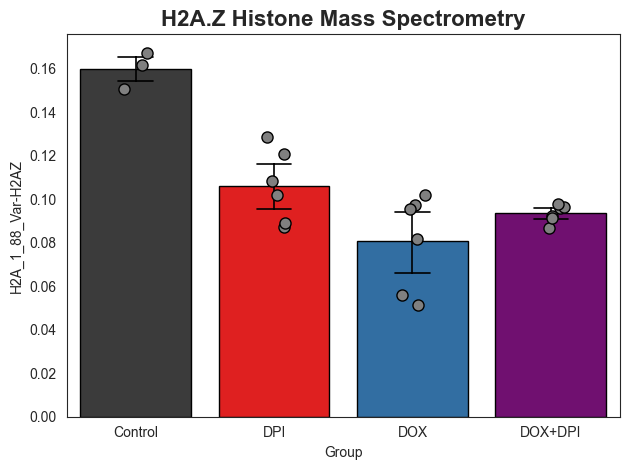

In [70]:
panova = stats_df.loc["H2A_1_88_Var-H2AZ"]["fdr_adjusted"]
f"{panova:.3e}"


sns.barplot(
    normalised_groups[["H2A_1_88_Var-H2AZ","Group"]],
    x="Group",
    y="H2A_1_88_Var-H2AZ",
    order=["Control","DPI","DOX","DOX+DPI"],
    palette=sample_cols,
    ci=90,capsize=.25,
    edgecolor="black",
    err_kws={
            "color": "black",    
            "linewidth": 1.2, 
        },
)

sns.stripplot(
    normalised_groups[["H2A_1_88_Var-H2AZ","Group"]],
    x="Group",
    y="H2A_1_88_Var-H2AZ",
    s=8,
    color="grey",edgecolor="black",linewidth=1,
    order=["Control","DPI","DOX","DOX+DPI"],
)

#plt.legend(title=f"p-ANOVA: {panova:.3e}",)
plt.title("H2A.Z Histone Mass Spectrometry",fontweight="bold",fontsize=16)
plt.tight_layout()
plt.savefig("h2az.svg")

NameError: name 'tukey_pval_df' is not defined

C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1427927508.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1427927508.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Tim\AppData\Local\Temp\ipykernel_7864\1427927508.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"p-ANOVA: {panova:.3e}",)


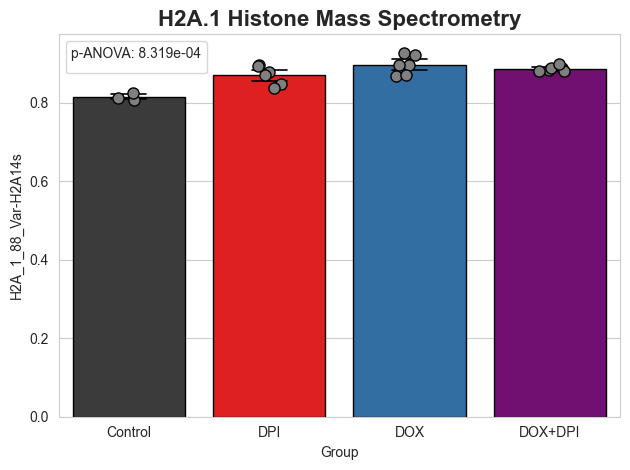

In [ ]:
panova = stats_df.loc["H2A_1_88_Var-H2A14s"]["fdr_adjusted"]
f"{panova:.3e}"


sns.set_style("whitegrid")

sns.barplot(
    normalised_groups[["H2A_1_88_Var-H2A14s","Group"]],
    x="Group",
    y="H2A_1_88_Var-H2A14s",
    order=["Control","DPI","DOX","DOX+DPI"],
    palette=sample_cols,
    ci=90,capsize=.25,
    edgecolor="black",
    err_kws={
            "color": "black",    
            "linewidth": 1.2, 
        },
)

sns.stripplot(
    normalised_groups[["H2A_1_88_Var-H2A14s","Group"]],
    x="Group",
    y="H2A_1_88_Var-H2A14s",
    s=8,
    color="grey",edgecolor="black",linewidth=1,
    order=["Control","DPI","DOX","DOX+DPI"],
)

plt.legend(title=f"p-ANOVA: {panova:.3e}",)  
plt.title("H2A.1 Histone Mass Spectrometry",fontweight="bold",fontsize=16)
plt.tight_layout()
plt.savefig("h2a1.svg")